In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from plot import plot_learning_perturbation, plot_learning
import matplotlib.pyplot as plt

#%matplotlib qt
%matplotlib widget
#%matplotlib inline

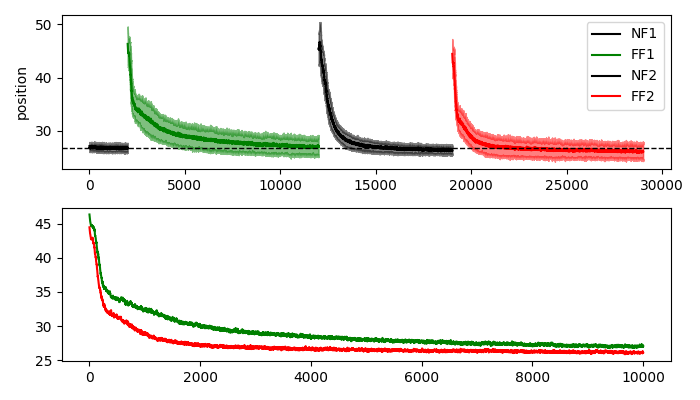

In [2]:
#phase = {'NF2':[0]}
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}

folder_name = 'Sim_all_32'
loss_type = 'position'
ignore = []


fig, ax = plot_learning(folder_name,num_model=20,w=1,phases=phase,loss_type=loss_type,figsize=(7,4),ignore=ignore,show_saving=True)
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(data_dir,'learning_curve_pos.png'),dpi=300)

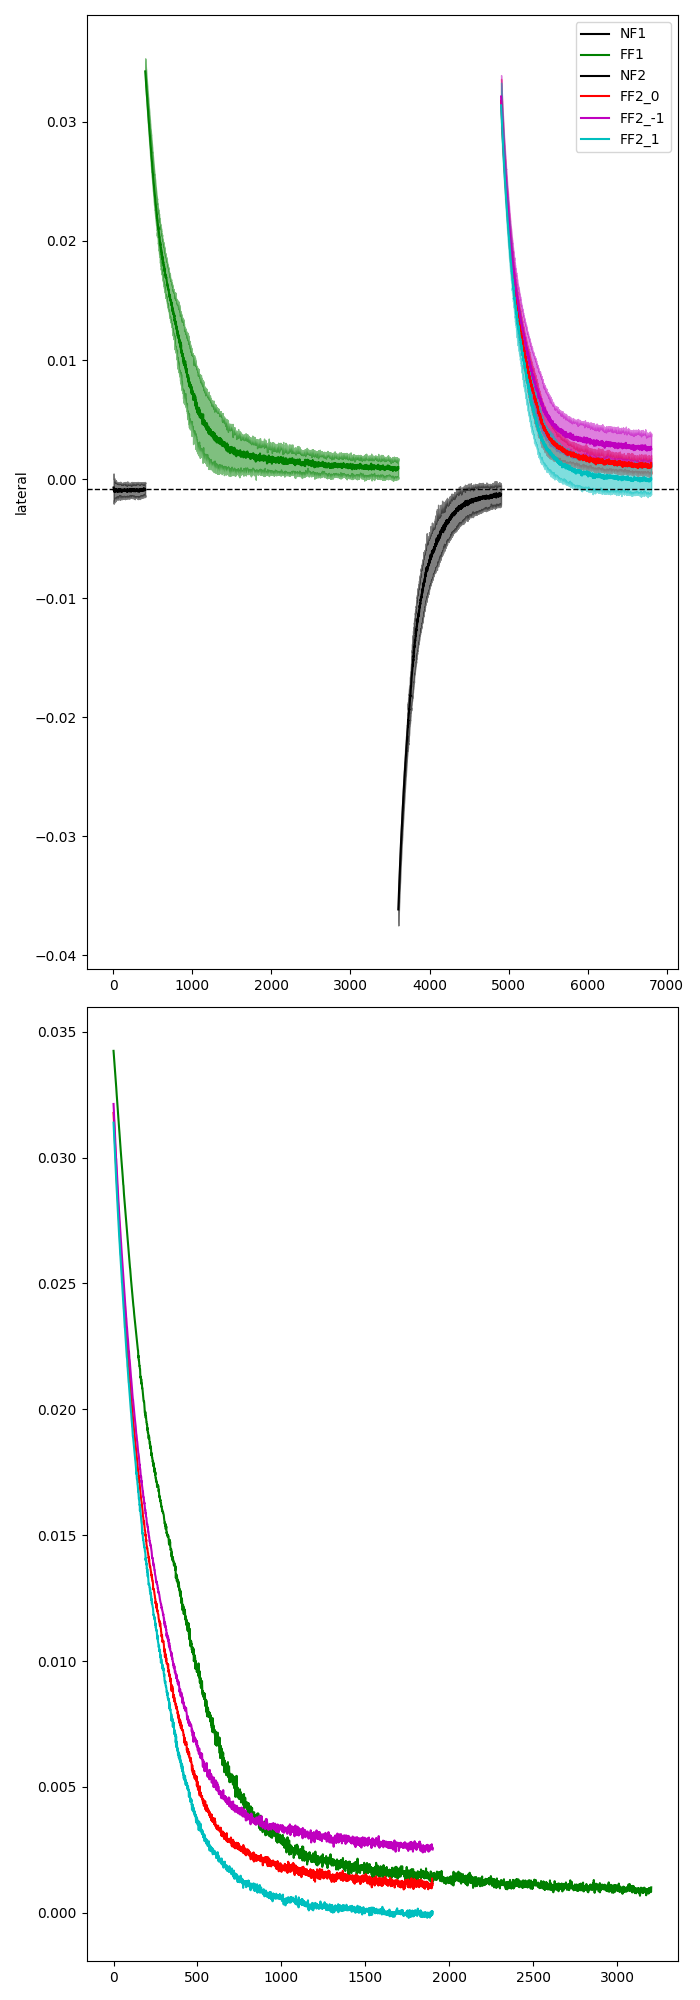

In [8]:
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
folder_name = 'Sim_simple2'

#%matplotlib widget

fig, ax = plot_learning_perturbation(folder_name,num_model=20,w=1,phases=phase,loss_type='lateral',figsize=(7,20),ignore=[],show_saving=True)
plt.tight_layout()
plt.show()